# Sequence: Evaluate Images

Use trained networks for sequence to evaluate test images.

Plot Confusion Matrix and GradCam images.

## Imports and Path definitions

In [1]:
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path

import cv2
import pandas as pd
import csv

import tensorflow as tf
from tensorflow.keras import datasets, models

from tensorflow.keras.applications import resnet
from tensorflow.keras.preprocessing import image

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

import time
import seaborn as sns

import numpy as np

%matplotlib inline
tf.__version__

'2.3.0'

### Define paths, adjust to your environment

In [2]:
# define neccessary directories
current_dir = Path().resolve()
project_dir = Path(current_dir).parent

data_dir = os.path.join(project_dir, 'data')
images_dir = os.path.join(data_dir, 'images')

models_dir = os.path.join(project_dir, 'models')

# print(f'project dir = {project_dir}')
# print(f'data dir    = {data_dir}')
# print(f'images dir  = {images_dir}')
# print(f'images dir  = {models_dir}')

In [3]:
# define directory of source files and add its path to sys.path as first entry
src_dir = os.path.join(project_dir, 'src')

# print(src_dir)

sys.path.insert(0, src_dir)

In [4]:
# import all functions needed from the source files
%load_ext autoreload
%autoreload 2
import evaluate as ev
import cnn_helper as hp

## Evaluate all images from a folder with the selected model and plot gradCAM images of them

### Define the pretrained model to use

In [5]:
# model trained for perspective 
model_name = 'sequence4_augment_150replace_epoch100_lre-4_closed_dropout.1_93acc.h5'
model_path = os.path.join(models_dir, model_name)
# model_path

In [6]:
model =  tf.keras.models.load_model(model_path)

In [7]:
model.summary()

Model: "func_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________________________________________________________________________

### Label type and labels configuration for evaluation

In [8]:
# label_type (sequence) and labels
label_type = 'sequence'
labels = ['DWI', 'T1', 'T1KM', 'T2']

### Evaluate test data

By default the test data images are stored in `perspective_df_test.csv`, respective `sequence_df_test.csv` in the notebooks directory.

In [9]:
csv_path = os.path.join(current_dir, 'sequence_df_test.csv')
# csv_path

In [10]:
#csv_path = os.path.join(test_images_dir, 'df_test.csv')
test_df = pd.read_csv(csv_path, index_col=[0])
print(f'test_df shape: {test_df.shape}')
test_df.head()

test_df shape: (35, 7)


,patient-id,perspective,sequence,perspective-sequence,labels,image-number,image-name
296,TCGA141037,COR,T1KM,COR-T1KM,"['COR', 'T1KM']",5,COR_T1KM_Glioma_GBM_TCGA141037_5.jpg
163,TCGA020068,AX,T2,AX-T2,"['AX', 'T2']",1,AX_T2_Glioma_GBM_TCGA020068_1.jpg
160,TCGA020060,AX,T2,AX-T2,"['AX', 'T2']",1,AX_T2_Glioma_GBM_TCGA020060_1.jpg
89,TCGA020011,AX,T1KM,AX-T1KM,"['AX', 'T1KM']",4,AX_T1KM_Glioma_GBM_TCGA020011_4.jpg
173,TCGA060121,AX,T2,AX-T2,"['AX', 'T2']",1,AX_T2_Glioma_GBM_TCGA060121_1.jpg


In [11]:
def get_predictions(model, df, train_classes, images_dir, rescale=True):
    x_col = 'image-name'
    y_col = 'y_true'
    # create data generator with rescaling only
    if rescale:
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1. / 255
        )
    # create data generator with resnet preprocessing only
    else:
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
        )
    
    print(datagen)
    print(images_dir)
    predictions = predict(model, df, images_dir, x_col, y_col, train_classes, datagen)
    df['predictions'] = pd.Series(list(predictions), index=df.index)
    df['y_pred'] = [np.argmax(pred) for pred in predictions]

    return df


def predict(model, df, images_dir, x_col, y_col, train_classes, datagen):
    generator = datagen.flow_from_dataframe(
        dataframe=df,
        directory=images_dir,
        x_col=x_col,
        y_col=y_col,
        class_mode='sparse',
        classes=train_classes,
        shuffle=False,
        target_size=(224, 224)
    )

    predictions = model.predict(
        generator,
        callbacks=None,
        max_queue_size=10,
        workers=1,
        use_multiprocessing=False,
        verbose=1)

    return predictions

## Confusion Matrix

In [12]:
test_df['y_true'] = test_df[label_type]
test_df = get_predictions(model, test_df, labels, images_dir)
ev.print_metrics(test_df, labels)

/Users/norbiorb/Data/git/propulsion/FinalProject/floydhub/mri-classifier/data/images
Found 35 validated image filenames belonging to 4 classes.
2/2 [==============================] - 0s 80ms/step


Metrics


,accuracy,f1_macro,f1_micro,precision_macro,precision_micro,recall_macro,recall_micro
0,0.971429,0.982676,0.971429,0.984375,0.971429,0.982143,0.971429


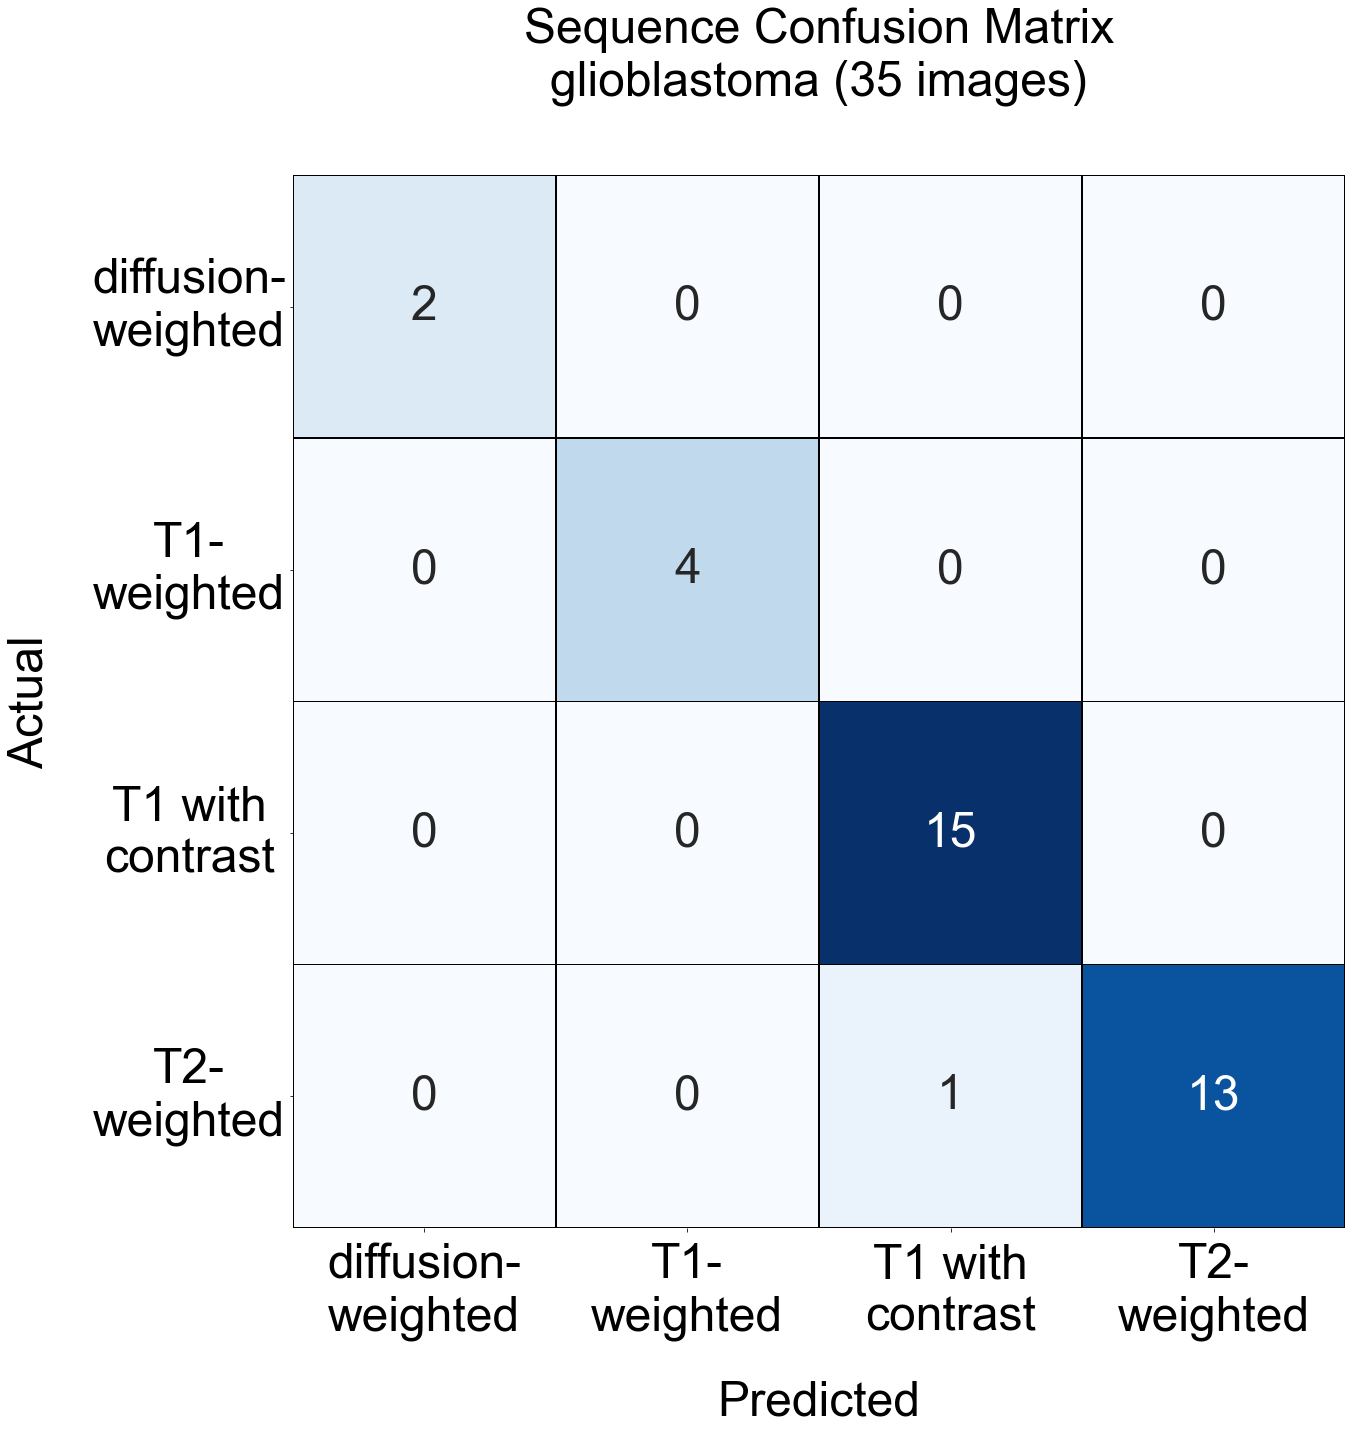

In [13]:
long_labels = ['diffusion-\nweighted', 'T1-\nweighted', 'T1 with\ncontrast', 'T2-\nweighted']

ev.plot_cm(
     test_df,
        labels,
        long_labels,
        'glioblastoma',
        label_type
)

## GradCAM Images

Plot GradCAM heatmap for a selection of correctly classified images

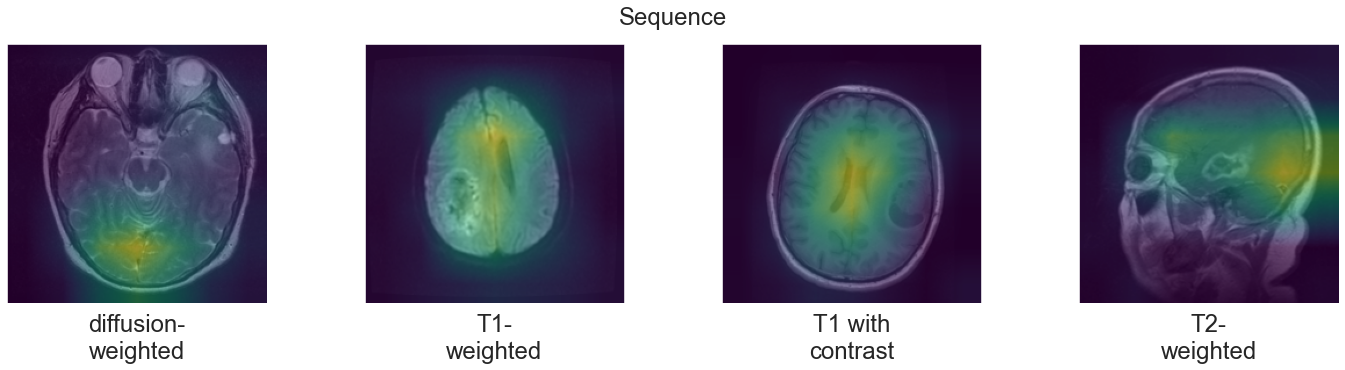

In [14]:
selected_images = [
    'AX_T2_Glioma_GBM_TCGA020006_1.jpg',
    'AX_DWI_Glioma_GBM_TCGA020059_3.jpg',
    'AX_T1_Glioma_GBM_TCGA020075_1.jpg', 
    'SAG_T1KM_Glioma_GBM_TCGA020046_2.jpg'
]

img_list = [os.path.join(images_dir, img) for img in selected_images]
# print(img_list)

actuals = ['DWI', 'T1', 'T1KM', 'T2']

heatmaps = ev.get_heatmaps(
    img_list=img_list,
    model=model,
    y_true=actuals,
    y_pred=actuals,
    classifier_layer_names = ['global_average_pooling2d', 'dropout', 'dense'],
    last_conv_layer_name='conv5_block3_out'
)

labels = ['diffusion-weighted', 'T1-weighted', 'T1 with contrast', 'T2-weighted']

ev.plot_gradcam_image(heatmaps, labels=long_labels, title='Sequence')